Notebook 4: Interface Demo

- Step 1: Setup Streamlit/Flask App
- Step 2: Load Trained Model
- Step 3: Build Upload & Prediction Function
- Step 4: Display Prediction + Grad‑CAM Visualization
- Step 5: Run App Locally/ Deploy

Using default test image: /content/PlantDiseaseDetection/split_data/test/Tomato__Tomato_YellowLeaf__Curl_Virus/29b48751-7688-4d68-9a79-34452889e936___UF.GRC_YLCV_Lab 01975.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Predicted class: Tomato__Tomato_YellowLeaf__Curl_Virus


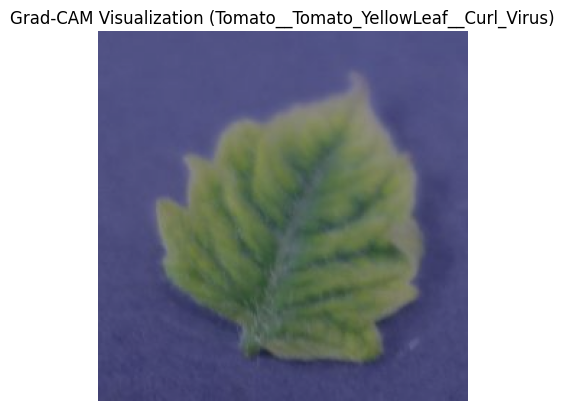

In [ ]:
# ================================
# Plant Disease Detection Project
# Notebook 4: Interactive Demo
# ================================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

# Step 1: Load trained model
model_path = "/content/PlantDiseaseDetection/models/resnet50_best.h5"
model = tf.keras.models.load_model(model_path)

# Step 2: Preprocess function
def preprocess_image(img):
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0
    return img

# Step 3: Grad-CAM function
def grad_cam(model, img_array, pred_class):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("conv5_block3_out").output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = heatmap.numpy()
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap

# Step 4: Get class labels from training generator
# (train_gen must be defined in Notebook 2)
class_labels = list(train_gen.class_indices.keys())

# Step 5: Pick a default test image automatically
test_dir = "/content/PlantDiseaseDetection/split_data/test"
classes = os.listdir(test_dir)
chosen_class = random.choice(classes)  # pick a random class folder
class_dir = os.path.join(test_dir, chosen_class)
img_file = random.choice(os.listdir(class_dir))  # pick a random image
img_path = os.path.join(class_dir, img_file)

print("Using default test image:", img_path)

# Step 6: Prediction + Visualization
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = preprocess_image(img)

preds = model.predict(img_array)
pred_class = np.argmax(preds[0])
pred_label = class_labels[pred_class]

print(f"✅ Predicted class: {pred_label}")

heatmap = grad_cam(model, img_array, pred_class)

img_cv = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Grad-CAM Visualization ({pred_label})")
plt.show()